# Constraints
Generally, a vector-valued constraints function, $g$, defines a solution $x$ as feasible if and only if $g_i(x) \le 0$ for all $i$. In order to optimize a function with some constraints, we use the class `ConstrainedFitnessAL` which constructs an Augmented Lagrangian objective function from the objective and arbitrary non-linear constraints.

For some positive and changing parameters $\lambda_i, \mu_i$, the constructed function is

$$x\mapsto f(x) + \sum_i (\lambda_i g_i + \frac{\mu_i}{2}g_i^2)$$

where $g_i := \max\left(g_i(x), -\frac{\lambda_i}{\mu_i}\right)$. This is not expected to work well if the constraint is a step function at the feasibility boundary.

For simplicity, let's consider a constraint that restricts the second variable to values $\le-1$. 


In [1]:
import cma

fun = cma.ff.elli  # we could use `functools.partial(cma.ff.elli, cond=1e4)` to change the condition number to 1e4
def constraints(x):
    return [x[1] - -1, x[1] - -0.9]  # constrain the second variable to <= -1, the second constraint is superfluous
cfun = cma.ConstrainedFitnessAL(fun, constraints)  # unconstrained function with adaptive Lagrange multipliers

x0 = 4 * [2]  # initial solution
sigma0 = 1    # initial standard deviation to sample new solutions

x, es = cma.fmin2(cfun, x0, sigma0, {'tolstagnation': 0}, callback=cfun.update)
x = es.result.xfavorite  # the original x-value may be meaningless
constraints(x)  # show constraint violation values

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=276847, Sun Jul 28 03:31:20 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 9.681898678923437e+05 1.0e+00 1.20e+00  1e+00  2e+00 0:00.0
    2     16 9.561538034053553e+06 1.4e+00 1.14e+00  1e+00  1e+00 0:00.0
    3     24 3.117827290270546e+06 1.5e+00 1.34e+00  1e+00  2e+00 0:00.0
  100    800 1.012224105283756e+02 4.8e+02 1.15e-01  5e-04  2e-01 0:00.1
  200   1600 1.000000000000318e+02 8.8e+02 4.37e-05  3e-09  3e-06 0:00.1
  228   1824 9.999999999999997e+01 1.3e+03 2.81e-06  6e-11  7e-08 0:00.1
termination on tolfun=1e-11 (Sun Jul 28 03:31:20 2024)
final/bestever f-value = 1.000000e+02 -1.069719e+06 after 1825/28 evaluations
incumbent solution: [3.2085880712698626e-08, -1.000000000046252, -1.452070775257454e-10, -1.535413485199042e-11]
std deviation: [7.199549832042527e-08, 6.671850641319045e-10, 6.937788971799779e-10, 6.181115349896813e-11]


[-4.625189120588402e-11, -0.10000000004625187]

The solution `es.result.xfavorite` is expected to be close to the feasible domain, but it may not be "stricly" feasible. To find a truly feasible solution, we can run a post-optimization like

In [2]:
c = es.countiter
x = cfun.find_feasible(es)
print("find_feasible took {} iterations".format(es.countiter - c))
constraints(x)  # is now <= 0

find_feasible took 0 iterations


[-4.1703307473994755e-11, -0.10000000004170329]

We can also plot the time evolution of feasibility and Augmented Lagrangian parameters and, of course, the standard plot: 

In [3]:
# "%matplotlib widget" gives interactive inline plots (pip install --upgrade jupyterlab ipympl); CAVEAT: it does not open a new figure automatically
# fix failing variable completion: %config Completer.use_jedi = False

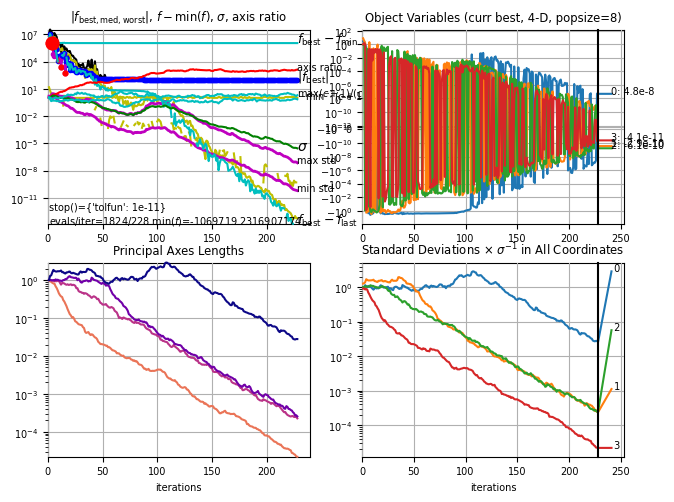

In [4]:
es.plot(xsemilog=True, x_opt=[0, -1] + (len(x0) - 2) * [0]);

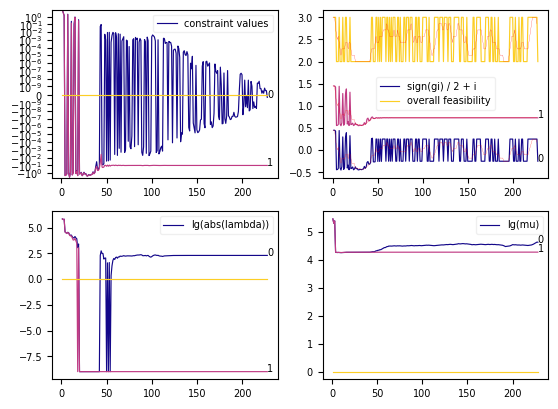

In [5]:
cfun.al.loggers.plot()

The `ConstrainedFitnessAL` class instance provides some more detailed information:

In [6]:
cfun.archives[0].archive  # non-dominated list of [f, aggregate(g)], feasible if aggregate(g) <= 0

[[99.99999994050326, 2.9748381535910084e-10],
 [99.99999994703606, 2.648238295321903e-10],
 [99.99999995283663, 2.358183648354384e-10],
 [99.99999995401211, 2.299394008531408e-10],
 [99.99999996010857, 1.994571174890325e-10],
 [99.9999999602351, 1.9882462343190355e-10],
 [99.99999996641168, 1.6794254875662773e-10],
 [99.9999999698915, 1.5054235635858504e-10],
 [99.99999997954492, 1.0227563240761128e-10],
 [100.00000000842667, 0]]

In [7]:
cfun.archives[0].archive.infos[-1]

{'x': array([-9.69600428e-07, -1.00000000e+00, -2.86682628e-08, -8.76790977e-09]),
 'f': 100.00000000842667,
 'g': [-4.1703307473994755e-11, -0.10000000004170329],
 'f_al': 100.000000000086,
 'g_al': [-8.34066362679346e-09, 0.0],
 'count': 1616}

Details about the best feasible solution can be found under its `info` attribute.


In [8]:
cfun.best_feas.info

{'x': array([-9.69600428e-07, -1.00000000e+00, -2.86682628e-08, -8.76790977e-09]),
 'f': 100.00000000842667,
 'g': [-4.1703307473994755e-11, -0.10000000004170329],
 'f_al': 100.000000000086,
 'g_al': [-8.34066362679346e-09, 0.0],
 'count': 1616}

# Ask-and-Tell Interface
We can use the underlying `CMAEvolutionStrategy` class, on which `cma.fmin2` is based, to get more control over the optimization loop.

In [9]:
# a more verbose way to run ``_, es = cma.fmin2(cfun, x0, sigma0)``

cfun = cma.ConstrainedFitnessAL(fun, constraints)  # unconstrained function with adaptive Lagrange multipliers
es = cma.CMAEvolutionStrategy(x0, sigma0)

while not es.stop():
    X = es.ask()  # sample len(X) candidate solutions
    es.tell(X, [cfun(x) for x in X])
    cfun.update(es)
    es.logger.add()  # for later plotting
    es.disp()
es.result_pretty()

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=310443, Sun Jul 28 03:31:21 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 1.041640879422284e+05 1.0e+00 1.02e+00  9e-01  1e+00 0:00.0
    2     16 2.138152759131010e+06 1.3e+00 9.66e-01  9e-01  1e+00 0:00.0
    3     24 4.139333076784072e+06 1.3e+00 9.71e-01  9e-01  1e+00 0:00.0
  100    800 1.014801097449026e+02 6.0e+02 2.82e-01  1e-03  7e-01 0:00.1
  200   1600 1.000000000000009e+02 1.0e+03 3.22e-05  2e-09  3e-06 0:00.1
  223   1784 1.000000000000000e+02 1.2e+03 4.30e-06  1e-10  1e-07 0:00.1
termination on tolfun=1e-11
final/bestever f-value = 1.000000e+02 -2.755548e+05 after 1784/70 evaluations
incumbent solution: [1.1845830205925065e-07, -0.9999999997784615, 1.7800212953989613e-09, -5.289102256476933e-12]
std deviation: [1.3048786311481704e-07, 6.727815397266928e-10, 1.5760997404903848e-09, 1.1802484838590602e-10]


CMAEvolutionStrategyResult(xbest=array([ 1.77966713, -2.83418742,  2.55361074, -0.05023962]), fbest=-275554.7578784954, evals_best=70, evaluations=1784, iterations=223, xfavorite=array([ 1.18458302e-07, -1.00000000e+00,  1.78002130e-09, -5.28910226e-12]), stds=array([1.30487863e-07, 6.72781540e-10, 1.57609974e-09, 1.18024848e-10]), stop={'tolfun': 1e-11})

If the function or constraints take additional arguments, they can be assigned ahead of time using [`functools.partial`](https://docs.python.org/3/library/functools.html), even to a mutable data type which makes it possible to change them dynamically.

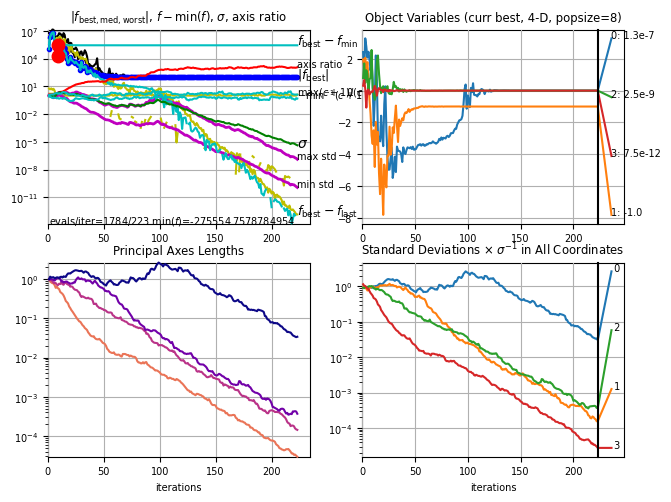

In [10]:
cma.plot();